In [10]:
# Config
#import pydsptools.config.pda as pda
#import pydsptools.biorad as biorad

# Analysis Preparation
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import chi2 # https://en.cppreference.com/w/cpp/numeric/random/chi_squared_distribution

# DSP Processing
#import pydsp.run.worker
#import pydsptools.biorad.parse as bioradparse

# PreProcessing
import pprint
import pyarrow as pa
import os
import subprocess
from pathlib import Path

# Visualization
#import pydsptools.plot as dspplt
import plotly.express as px
import matplotlib.pyplot as plt

# Script Description

* 이 스크립트는 baseline fitting algorithm 비교 분석용으로 사용된다.
* `3.baseline-analysis.ipynb` 는 다음 2가지의 data를 전처리한다.   

# 분석

## Read Multiple Parquets

### Merge Dataframes

In [11]:
def load_and_prepare_parquet(i_file_path, i_selected_columns=None, i_combo_key_columns=None, i_rename_columns=None):
    '''
    load parquets and prepare dataframe for analyses
    
    Args:
    - i_file_path: a file_path where parquet files exist.
    - i_selected_columns: a list of the column names used for a data analysis
    - i_combo_key_columns: a list of the column names used for creating a combination key and merging several data frames
    - i_rename_columns: a list of the column names for renaming
    
    Returns:
    - o_df: a dataframe
    '''

    o_df = pl.scan_parquet(i_file_path).collect().to_pandas()
    if i_selected_columns:
        o_df = o_df[i_selected_columns].copy()
    if i_combo_key_columns:
        o_df['combo_key'] = o_df.apply(lambda x: ' '.join(str(x[col]) for col in i_combo_key_columns), axis=1)
    if i_rename_columns:
        o_df.rename(columns = i_rename_columns, inplace=True)
    
    return o_df


### Detecting Noisy Signlas

In [32]:
# Noise Naive Detection
def detect_noise_naively(i_signal, i_threshold=1.28):
    '''
    detect noisy signals. 10 cycle 버리고 다시 카운트할 것
    
    Args:
    - i_signal: a rfu signal with a data type as a list
    - i_threshold: the z score = 1.65 

    Returns:
    - o_result: [any(outliers),outlierness_metric, outliers] with the data types of [boolean, a real number, a list of outliers ] 
    '''
    i_signal = i_signal[10:]
    if i_signal.size == 0:  # Check if the signal is empty
        return [False, 0, []]  # Return default values for empty signals
    
    mean = np.mean(i_signal)
    std = np.std(i_signal)

    if std == 0:  # Prevent division by zero
        return [False, 0, []]

    z_scores = [(point - mean) / std for point in i_signal]
    outliers = [score for score in z_scores if abs(score) > i_threshold]
    outliers_boolean = [abs(score) > i_threshold for score in z_scores]
    outlier_existence = 1 if any(outliers_boolean) else 0
    outlierness_metric_sum = sum(abs(score) for score in z_scores if abs(score) > i_threshold)
    outlierness_metric = outlierness_metric_sum / len(outliers) if len(outliers) != 0 else 0
    o_result = [outlier_existence, outlierness_metric, outliers]
    return o_result

# detect white noise signals
def autocorrelation(i_signal, i_lag):
    '''
    this function calcuate autocorrelation value of a signal

    Args:
    - i_signal: a PCR signal
    - i_lag: a lag window

    Returns:
    - o_result: an autocorreation value
    '''
    n = len(i_signal)
    mean_x = np.mean(i_signal)
    denominator = np.sum((i_signal - mean_x) ** 2)
    numerator = np.sum((i_signal[:-i_lag] - mean_x) * (i_signal[i_lag:] - mean_x))
    o_result = numerator / denominator 
    return o_result

def test_white_noise(i_signal, i_max_lag):
    '''
    this function tests if a signal is white noise.

    args:
    - i_signal: a PCR signal
    - i_max_lag: a max lag

    return:
    - o_result: a test statistic
    '''
    n = len(i_signal)
    statistic = 0
    for lag in range(1, i_max_lag + 1):
        rho = autocorrelation(i_signal, lag)
        statistic += (n * (n + 2) * rho ** 2) / (n - lag)
    p_value = 1 - chi2.cdf(statistic, i_max_lag)
    o_result = [statistic, p_value]
    return o_result

### Preprocessing

In [34]:
def get_column_percentiles(i_data, i_column_name):
    '''
    Calculate the percentile rank of each score in the specified column of a DataFrame.
    
    Args:
    - i_data: DataFrame containing the metric scores.
    - i_column_name: The name of the metric column whose scores' percentile ranks are to be calculated.
    
    Returns:
    - o_percentiles: A Series containing the percentile ranks of the scores in the specified column.
    '''
    def get_percentile(i_sorted_data, i_value):
        '''
        Calculate the percentile rank of a metric score relative to sorted scores.
        
        Args:
        - i_sorted_data: Sorted numpy array of scores.
        - i_value: The score whose percentile rank is to be calculated.
        
        Returns:
        - o_percent: The percentile rank of the score.
        '''
        if not i_sorted_data.size:  # Check if sorted data is empty
            return np.nan  # Return NaN for empty data
        count = np.sum(i_sorted_data <= i_value)
        o_percent = 100.0 * count / len(i_sorted_data)
        return np.round(o_percent, 1)
    
    non_empty_values = i_data[i_column_name].apply(lambda x: x if x else np.nan).dropna()
    i_sorted_data = np.sort(non_empty_values.values)
    o_percentiles = non_empty_values.apply(lambda x: get_percentile(i_sorted_data, x))
    
    return o_percentiles

def process_column_for_outliers(i_data, i_column, i_groupby_columns):
    """
    Process a given column for outlier detection and related metrics using detect_noise_naively().
    
    Args:
    - i_data: DataFrame to process.
    - i_column: The name of the column to process for outliers.
    - i_groupby_columns: Columns names to group by for percentile calculations.
    
    Returns:
    - o_result: Updated DataFrame with new outlier-related columns.
    """
    # Detect outliers and calculate outlierness metric
    i_data[f'outlier_naive_{i_column}'] = i_data[i_column].apply(lambda cell: detect_noise_naively(cell)[0])
    i_data[f'outlier_naive_metric_{i_column}'] = i_data[i_column].apply(lambda cell: detect_noise_naively(cell)[1])
    
    # Calculate 95th percentile cutoff for outlierness metric
    i_data[f'outlier_navie_cutoff_{i_column}'] = i_data.groupby(i_groupby_columns)[f'outlier_naive_metric_{i_column}'].transform(lambda x: np.percentile(x, 95))
    
    # Calculate metric percentiles within each group
    i_data[f'outlier_metric_percentile_{i_column}'] = i_data.groupby(i_groupby_columns).apply(lambda grp: get_column_percentiles(grp, f'outlier_naive_metric_{i_column}')).reset_index(level=i_groupby_columns, drop=True)
    
    o_result = i_data
    return o_result

def process_column_for_outliers_temp(i_data, i_column, i_groupby_columns, i_function):
    """
    Process a given column for outlier detection and related metrics using i_function=detect_noise_naively() or test_white_noise().
    
    Args:
    - i_data: DataFrame to process.
    - i_column: The name of the column to process for outliers.
    - i_groupby_columns: Columns names to group by for percentile calculations.
    - i_function: The function used to detect outliers and calculate outlierness metrics. It determines the naming convention.
    
    Returns:
    - o_result: Updated DataFrame with new outlier-related columns.
    """
    prefix = 'naive' if 'naive' in i_function.__name__ else 'white' if 'white' in i_function.__name__ else 'other'
    
    # Detect outliers and calculate outlierness metric
    i_data[f'outlier_{prefix}_{i_column}'] = i_data[i_column].apply(lambda cell: i_function(cell)[0])
    i_data[f'outlier_{prefix}_metric_{i_column}'] = i_data[i_column].apply(lambda cell: i_function(cell)[1])
    i_data[f'outlier_{prefix}_cutoff_{i_column}'] = i_data.groupby(i_groupby_columns)[f'outlier_{prefix}_metric_{i_column}'].transform(lambda x: np.percentile(x, 95))
    i_data[f'outlier_{prefix}_metric_percentile_{i_column}'] = (i_data.groupby(i_groupby_columns)
                                                                .apply(lambda grp: get_column_percentiles(grp, f'outlier_{prefix}_metric_{i_column}'),include_groups=False)
                                                                .reset_index(level=i_groupby_columns, drop=True))
    o_result = i_data
    return o_result

# 시각화

## Plotting Single Well

In [14]:
def plot_single_well(i_data, i_pcrd, i_channel, i_well, i_color=None):
    filtered_data = i_data.query("`name` == @i_pcrd & `channel` == @i_channel & well == @i_well")
    '''
    this function plot a single well.

    args:
    - i_data 
    - i_color
    - i_pcrd
    - i_channel
    - i_i_temperature
    - i_well

    return:
    - result: a plt.plot for a single well
    '''
    # Green: fam_data 
    # Orange: hex_data 
    # Red: cRed_data
    # Blue: q670_data

    for index, row in filtered_data.iterrows():
        preproc_rfu = row['preproc_rfu'] 
        cycle = list(range(len(preproc_rfu))) 
        #color = i_color[row['temperature']]
        plt.plot(cycle, preproc_rfu, label=f'Line {index}', color = i_color, alpha= 0.2, ms=10)

## Plotting All the Wells

In [48]:

def find_sub_extremes(i_signal):
    '''
    Find the maximum and minimum values within each cell in a DataFrame column,
    then find the overall max and min for the column. The output is used for setting the axis limits.
    Args:
        - i_signal: a list of the signal values of a column of a dataframe
    Returns:
        - o_result: a list of min and max of the signal values
    '''
    def process_cell(i_signal):
        '''
        Check if i_signal is list-like and not empty
        Args:
            - i_signal: a list of the signal values of a column of a dataframe
        Returns:
            - o_result: a list of min and max of the signal values
        '''
        
        if isinstance(i_signal, (list, np.ndarray, pd.Series)) and len(i_signal):
            o_result = pd.Series([np.max(i_signal), np.min(i_signal)], index=['max', 'min'])
        else:
            o_result = pd.Series([pd.NA, pd.NA], index=['max', 'min'])
        return o_result
    
    extremes_df = i_signal.apply(process_cell)
    extremes_df = extremes_df.dropna()
    
    if extremes_df.empty:
        return [None, None]
    
    overall_max = extremes_df['max'].max()
    overall_min = extremes_df['min'].min()
    o_result = [overall_max, overall_min]
    return o_result

def find_global_extremes(i_data):
    '''
    Find the global extremes for the input dataframe, 'i_data'.
    Args:
        - i_data: a dataframe
    Returns:
        - o_result: a list of min and max of the signal values
    '''
    extremes_results = {column: find_sub_extremes(i_data[column]) for column in i_data.columns}
    overall_max = float('-inf')
    overall_min = float('inf') 
    
    for key in extremes_results.keys():
        if key in extremes_results:
            column_max, column_min = extremes_results[key]
            overall_max = max(overall_max, column_max)
            overall_min = min(overall_min, column_min)
    o_result = [overall_max,overall_min]
    return o_result

def get_comparison_metrics(i_grouped_data,i_columns):
    '''
    Calculate absolute_means_sum and squared_means_sum for the columns ['analysis_absd_orig', 'original_rfu_cfx', 'basesub_absd_orig', 'analysis_absd_orig_strep']
    
    Args:
        i_grouped_data: a dataframe that is grouped of the 'filtered_data' using groupby() in pandas
        i_columns: a list of columns to calculate metrics
    Returns:
        o_result: a series of metrics
    '''
    metrics = {}
    
    for column in i_columns:
        # Filtering out empty lists and concatenating non-empty lists into a numpy array
        non_empty_lists = i_grouped_data[column].apply(lambda x: len(x) > 0)
        length = non_empty_lists.sum()
        absolute_means_sum = i_grouped_data[column][non_empty_lists].apply(lambda x: np.abs(x).mean()).sum()
        squared_means_sum = i_grouped_data[column][non_empty_lists].apply(lambda x: (x**2).mean()).sum()
        metric_array = np.concatenate(i_grouped_data[column][non_empty_lists].to_numpy())
        
        if metric_array.size > 0:
            column_metrics = {
                'length': length,
                'absolute_sum': round(absolute_means_sum, 2),  
                'squared_sum': round(squared_means_sum, 2),
                'mse': round(squared_means_sum/length, 2),
                'mae': round(absolute_means_sum/length, 2)
            }
        else:
            column_metrics = {
                'length': 0,
                'absolute_sum': 0, 
                'squared_sum': 0,
                'mse': 0,
                'mae': 0
            }
        metrics[column] = column_metrics
        o_result = pd.Series(metrics)
    return o_result

def plot_baseline_subtractions(i_data, i_pcrd, i_channel, i_temperature, colors=None):
    '''
    Plot the results of the baseline-fitting algorithms to intuitively compare their overall performance.
    
    Args:
        i_data: a dataframe, a result of merging the DSP execution result of raw RFU and the RFU baseline-subtracted by CFX manager, by the auto-baseline module, by the strep assay, and by the newly-developed algorithms.
        i_pcrd:
        i_channel:
        i_temperature:
        colors:
    
    Returns:
        Output: 6 Pannels of plt.subplots()
    '''
    

    fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #(15, 10)

    baseline_data = i_data[['basesub_absd_orig', 'original_rfu_cfx','analysis_absd_orig_strep']]
    limits = find_global_extremes(baseline_data)
    
    titles = ['[Raw] RFU', '[DSP] Original ABSD', '[Auto] Baseline-Subtracted RFU', '[CFX] Baseline-Subtracted RFU', 
        '[Strep] Baseline-Subtracted RFU', '[New] Baseline-Subtracted RFU', '[Empty] Empty Pannel', '[Outlier Metric] Distribution']
    data_keys = ['original_rfu', 'analysis_absd_orig', 'basesub_absd_orig', 'original_rfu_cfx', 
                 'analysis_absd_orig_strep', None, None, 'outlier_naive_metric_original_rfu']
    grouping_columns = ['analysis_absd_orig', 'original_rfu_cfx', 'basesub_absd_orig', 'analysis_absd_orig_strep']
    error_metrics_df = (i_data
                        .groupby(['name', 'channel', 'temperature'])
                        .apply(lambda x: get_comparison_metrics(x, grouping_columns))
                        .reset_index(drop=True))
    error_metrics_dict = error_metrics_df.iloc[0]
        
    metric_min=round(i_data['outlier_naive_metric_original_rfu'].min(),2)
    metric_max=round(i_data['outlier_naive_metric_original_rfu'].max(),2)

    for (i, j), ax, title, key in zip(np.ndindex(axs.shape), axs.flat, titles, data_keys):
        if key:  
            rfu_values = []
            for index, row in i_data.iterrows():
                rfu = row[key]
                rfu_values.extend(rfu)
                cycle = list(range(len(rfu)))
                #color = colors[row['temperature']]
                if (i,j) == (0,0):
                    ax.text(0.05, 0.98, f"N: {i_data.shape[0]}\nOutlier Naive Metric: [{metric_min},{metric_max}]", 
                        verticalalignment='top', horizontalalignment='left', 
                        transform=ax.transAxes)
                elif (i,j) == (0,1):
                    ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['analysis_absd_orig']['length'],2)}\nMAE: {round(error_metrics_dict['analysis_absd_orig']['mae'],2)}\nMSE: {round(error_metrics_dict['analysis_absd_orig']['mse'],2)}", 
                        verticalalignment='top', horizontalalignment='left', 
                        transform=ax.transAxes)
                elif (i,j) == (0,2):
                    ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['basesub_absd_orig']['length'],2)}\nMAE: {round(error_metrics_dict['basesub_absd_orig']['mae'],2)}\nMSE: {round(error_metrics_dict['basesub_absd_orig']['mse'],2)}", 
                        verticalalignment='top', horizontalalignment='left', 
                        transform=ax.transAxes)
                elif (i,j) == (1,0):
                    ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['original_rfu_cfx']['length'],2)}\nMAE: {round(error_metrics_dict['original_rfu_cfx']['mae'],2)}\nMSE: {round(error_metrics_dict['original_rfu_cfx']['mse'],2)}", 
                        verticalalignment='top', horizontalalignment='left', 
                        transform=ax.transAxes)
                elif (i,j) == (1,1):
                    ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['analysis_absd_orig_strep']['length'],2)}\nMAE: {round(error_metrics_dict['analysis_absd_orig_strep']['mae'],2)}\nMSE: {round(error_metrics_dict['analysis_absd_orig_strep']['mse'],2)}", 
                        verticalalignment='top', horizontalalignment='left', 
                        transform=ax.transAxes)
                elif (i, j) == (1, 2):
                    ax.text(0.05, 0.98, "Undeveloped", verticalalignment='top', horizontalalignment='left', 
                        transform=ax.transAxes)
                ax.plot(cycle, rfu, alpha=0.5)
                ax.axhline(y=0,color='black',linestyle='dotted',linewidth=2)
                ax.set_title(title)
            if (i,j) == (0,0):
                if rfu_values:
                    ax.set_ylim([min(rfu_values)*0.9,max(rfu_values)*1.2])
            else:
                ax.set_ylim(min(limits)*1.2,max(limits)*1.5)        
        else:  
            ax.set_title(title)

    fig.suptitle(f'PCRD: {i_pcrd}\nChannel: {i_channel}, Temperature: {i_temperature}, The Number of Signals: {i_data.shape[0]}', 
                 ha = 'left', x=0.02, fontsize=15)
    plt.tight_layout()
    plt.show()

In [16]:
# preprocessing codes

## Read parquets

# cfx_columns = ['name', 'steps', 'consumable', 'well', 'channel', 'temperature', 'original_rfu']
# auto_baseline_columns = ['name', 'steps', 'consumable', 'well', 'channel', 'temperature', 'basesub_resultwell', 'basesub_dataprocnum', 'basesub_rd_diff', 'basesub_ivd_cdd_output', 'basesub_cff', 'basesub_scd_fit', 'basesub_r_p2', 'basesub_efc', 'basesub_absd_orig', 'basesub_absd']
# strep_columns = ['name', 'steps', 'consumable', 'well', 'channel', 'temperature', 'analysis_absd']
# combo_key_columns = ['name', 'consumable', 'channel', 'temperature', 'well']
# 
# 
# raw_df = load_and_prepare_parquet("./data/pda-raw-sample/computed/example1/config__dsp2_orig/dsp/*.parquet", i_combo_key_columns=combo_key_columns)
# cfx_df = load_and_prepare_parquet("./data/cfx-baseline-subtracted/computed/example1/config__dsp2_orig/dsp/*.parquet", cfx_columns, combo_key_columns, {'original_rfu': 'original_rfu_cfx'})
# auto_baseline_df = load_and_prepare_parquet("./data/autobaseline-subtracted/computed/example1/config__dsp2_orig/basesub/*.parquet", auto_baseline_columns, combo_key_columns)
# strep_df = load_and_prepare_parquet("./data/strep_assay/computed/config__240213_multiamp_research/dsp/*.parquet", strep_columns, combo_key_columns,{'analysis_absd': 'analysis_absd_orig_strep'})
# 
# ## create a combination key to merge the dataframes
# auto_baseline_df = auto_baseline_df[auto_baseline_columns[6:] + ['combo_key']]  # Adjust index as necessary
# strep_df = strep_df[['analysis_absd_orig_strep','combo_key']]  
# 
# ## Merge dataframes
# merged_data = cfx_df.merge(raw_df, on='combo_key').merge(auto_baseline_df, on='combo_key').merge(strep_df, on ='combo_key')
# negative_data = merged_data[merged_data['final_ct'] < 0]

## the Running Script

In [35]:
# read data
merged_data = pd.read_parquet('../../data/baseline_subtraction.parquet')

# Detect outliers naively
columns_to_process = ['original_rfu'] #['analysis_absd_orig', 'original_rfu_cfx', 'basesub_absd_orig']
groupby_columns = ['channel', 'temperature']

for column in columns_to_process:
    merged_data = process_column_for_outliers(merged_data, column, groupby_columns)

# Filter data
channels=merged_data['channel'].unique()
temperatures=merged_data['temperature'].unique()
plate_names=merged_data['name'].unique()
well_names=merged_data['well'].unique()
colors = {'Low':'blue','High':'red'}
pcrd_name = merged_data['name'].unique()[0]
channel_name = merged_data['channel'].unique()[1]
temperature_name = merged_data['temperature'].unique()[0]


# Explode Merged Data
#unested_merged_data = merged_data.explode(['original_rfu','preproc_rfu','original_rfu_cfx','analysis_absd_orig'])
#unested_merged_data['cycle']=unested_merged_data.groupby('combo_key').cumcount()
#unested_merged_data[(unested_merged_data['name']==unested_merged_data['name'][0].iloc[0])&(unested_merged_data['well']==unested_merged_data['well'][0].iloc[0])&(unested_merged_data['channel']==unested_merged_data['channel'][0].iloc[0])]


(array([1., 0., 1., 1., 2., 4., 5., 2., 2., 7., 4., 5., 2., 7., 5., 3., 3.,
        9., 6., 3., 4., 1., 1., 3., 2., 1., 2., 1., 3., 2., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 1.]),
 array([1.39515446, 1.41399765, 1.43284084, 1.45168403, 1.47052722,
        1.48937041, 1.5082136 , 1.52705679, 1.54589998, 1.56474318,
        1.58358637, 1.60242956, 1.62127275, 1.64011594, 1.65895913,
        1.67780232, 1.69664551, 1.7154887 , 1.73433189, 1.75317508,
        1.77201828, 1.79086147, 1.80970466, 1.82854785, 1.84739104,
        1.86623423, 1.88507742, 1.90392061, 1.9227638 , 1.94160699,
        1.96045019, 1.97929338, 1.99813657, 2.01697976, 2.03582295,
        2.05466614, 2.07350933, 2.09235252, 2.11119571, 2.1300389 ,
        2.1488821 ]),
 <BarContainer object of 40 artists>)

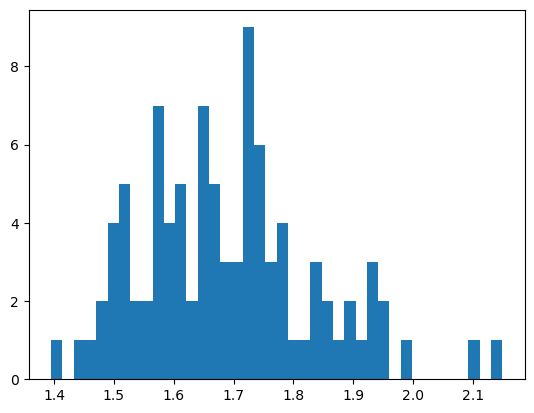

In [44]:
temp = merged_data.query("`name` == @pcrd_name & `channel` == @channel_name & `temperature` == @temperature_name & `final_ct` < 0")
plt.hist(temp['outlier_naive_metric_original_rfu'], bins=40)

In [49]:
filtered_data = merged_data.query("`name` == @pcrd_name & `channel` == @channel_name & `temperature` == @temperature_name & `final_ct` < 0 & `outlier_naive_metric_original_rfu` > 1.8")

TypeError: <lambda>() got an unexpected keyword argument 'include_groups'

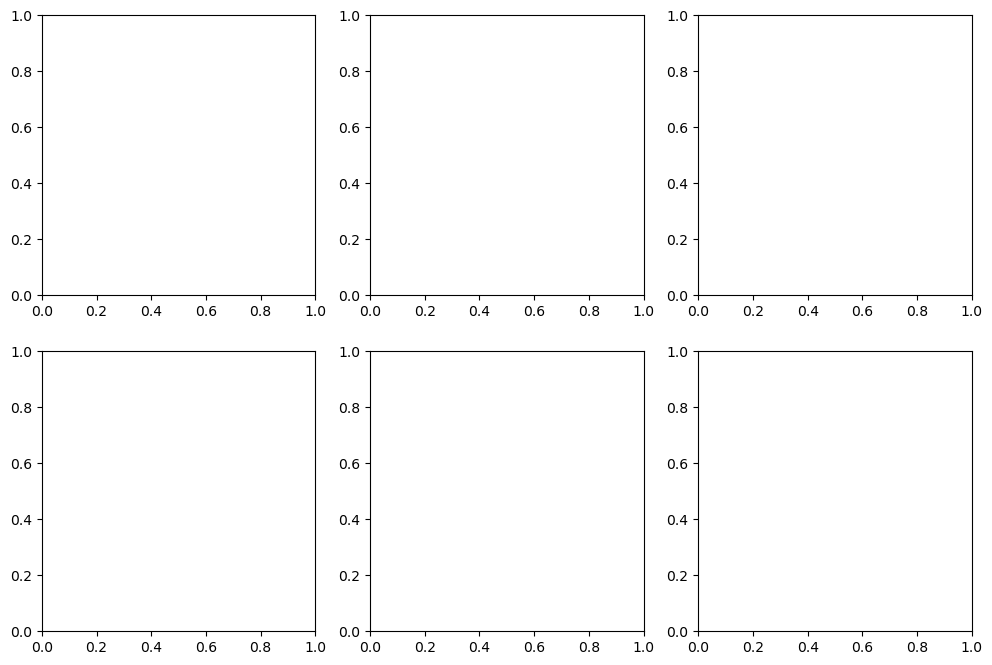

In [46]:
i_data = filtered_data
i_pcrd = pcrd_name
i_channel = channel_name
i_temperature = temperature_name

fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #(15, 10)

baseline_data = i_data[['basesub_absd_orig', 'original_rfu_cfx']]
limits = find_global_extremes(baseline_data)
titles = ['[Raw] RFU', '[DSP] Original ABSD', '[Auto] Baseline-Subtracted RFU', '[CFX] Baseline-Subtracted RFU', 
        '[Strep] Baseline-Subtracted RFU', '[New] Baseline-Subtracted RFU', '[Empty] Empty Pannel', '[Outlier Metric] Distribution']
data_keys = ['original_rfu', 'analysis_absd_orig', 'basesub_absd_orig', 'original_rfu_cfx', 
                 'analysis_absd_orig_strep', None, None, 'outlier_naive_metric_original_rfu']
grouping_columns = ['analysis_absd_orig', 'original_rfu_cfx', 'basesub_absd_orig', 'analysis_absd_orig_strep']

error_metrics_df = (i_data
                        .groupby(['name', 'channel', 'temperature'])
                        .apply(lambda x: get_comparison_metrics(x, grouping_columns),include_groups=False)
                        .reset_index(drop=True))

error_metrics_dict = error_metrics_df.iloc[0]
    
metric_min=round(i_data['outlier_naive_metric_original_rfu'].min(),2)
metric_max=round(i_data['outlier_naive_metric_original_rfu'].max(),2)

for (i, j), ax, title, key in zip(np.ndindex(axs.shape), axs.flat, titles, data_keys):
    if key:  
        rfu_values = []
        for index, row in i_data.iterrows():
            rfu = row[key]
            rfu_values.extend(rfu)
            cycle = list(range(len(rfu)))
            #color = colors[row['temperature']]
            if (i,j) == (0,0):
                ax.text(0.05, 0.98, f"N: {i_data.shape[0]}\nOutlier Naive Metric: [{metric_min},{metric_max}]", 
                    verticalalignment='top', horizontalalignment='left', 
                    transform=ax.transAxes)
            elif (i,j) == (0,1):
                ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['analysis_absd_orig']['length'],2)}\nMAE: {round(error_metrics_dict['analysis_absd_orig']['mae'],2)}\nMSE: {round(error_metrics_dict['analysis_absd_orig']['mse'],2)}", 
                    verticalalignment='top', horizontalalignment='left', 
                    transform=ax.transAxes)
            elif (i,j) == (0,2):
                ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['basesub_absd_orig']['length'],2)}\nMAE: {round(error_metrics_dict['basesub_absd_orig']['mae'],2)}\nMSE: {round(error_metrics_dict['basesub_absd_orig']['mse'],2)}", 
                    verticalalignment='top', horizontalalignment='left', 
                    transform=ax.transAxes)
            elif (i,j) == (1,0):
                ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['original_rfu_cfx']['length'],2)}\nMAE: {round(error_metrics_dict['original_rfu_cfx']['mae'],2)}\nMSE: {round(error_metrics_dict['original_rfu_cfx']['mse'],2)}", 
                    verticalalignment='top', horizontalalignment='left', 
                    transform=ax.transAxes)
            elif (i,j) == (1,1):
                ax.text(0.05, 0.98, f"n: {round(error_metrics_dict['analysis_absd_orig_strep']['length'],2)}\nMAE: {round(error_metrics_dict['analysis_absd_orig_strep']['mae'],2)}\nMSE: {round(error_metrics_dict['analysis_absd_orig_strep']['mse'],2)}", 
                    verticalalignment='top', horizontalalignment='left', 
                    transform=ax.transAxes)
            elif (i, j) == (1, 2):
                ax.text(0.05, 0.98, "Undeveloped", verticalalignment='top', horizontalalignment='left', 
                    transform=ax.transAxes)
            ax.plot(cycle, rfu, alpha=0.5)
            ax.axhline(y=0,color='black',linestyle='dotted',linewidth=2)
            ax.set_title(title)
        if (i,j) == (0,0):
            if rfu_values:
                ax.set_ylim([min(rfu_values)*0.9,max(rfu_values)*1.2])
        else:
            ax.set_ylim(-abs(min(limits))*1.2,max(limits)*1.5)        
    else:  
        ax.set_title(title)
fig.suptitle(f'PCRD: {i_pcrd}\nChannel: {i_channel}, Temperature: {i_temperature}, The Number of Signals: {i_data.shape[0]}', 
             ha = 'left', x=0.02, fontsize=15)
plt.tight_layout()
plt.show()

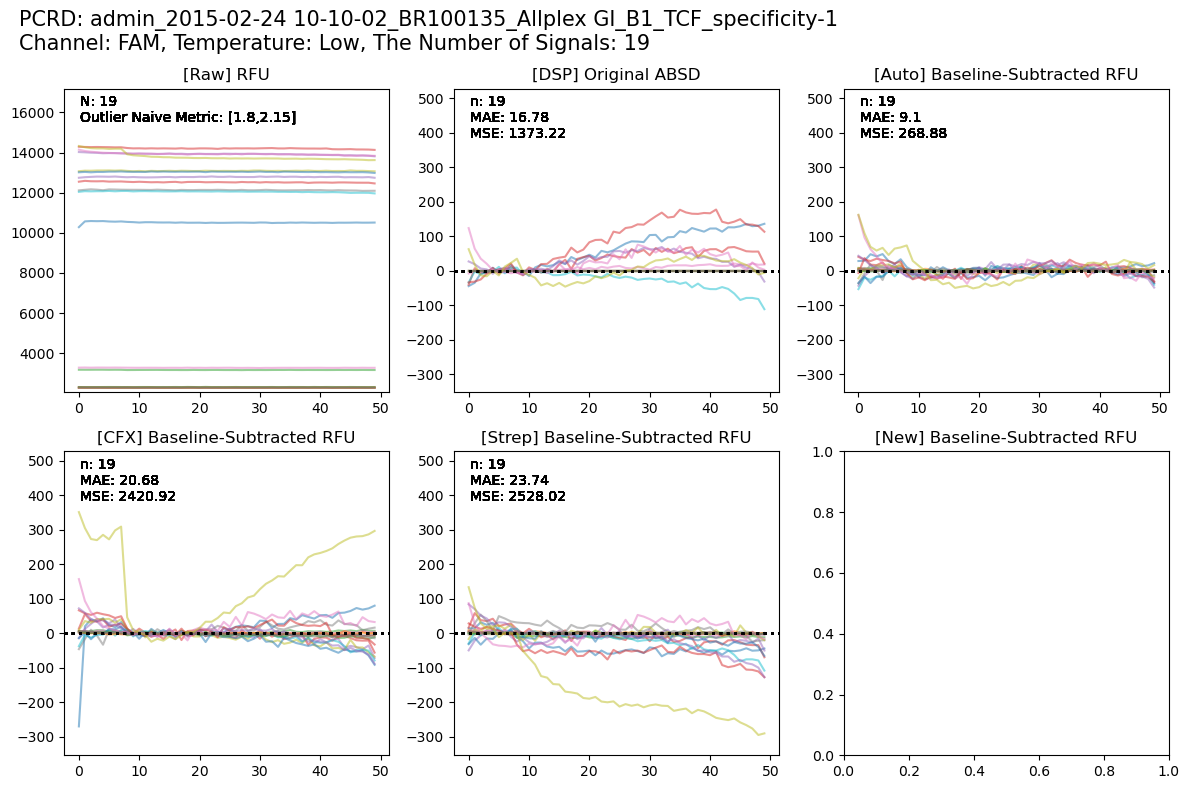

In [50]:
# Plot All the plate wells
plot_baseline_subtractions(filtered_data,pcrd_name,channel_name,temperature_name)

Overall Trend: Upward
Detected Patterns: ['Jumps', 'Inflections (possible V-shape or U-shape)']


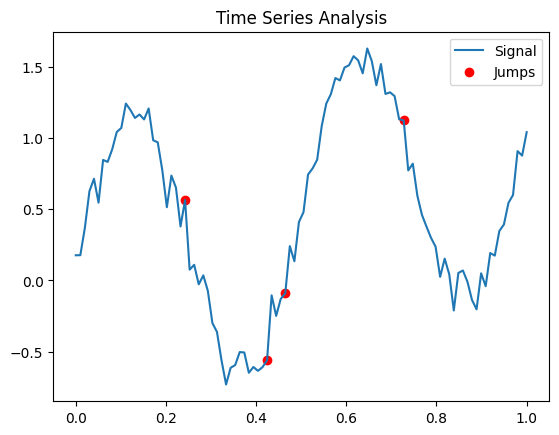

In [12]:
def detect_trend_and_pattern(signal):
    diff = np.diff(signal)
    signs = np.sign(diff)
    inflection_points = np.diff(signs) != 0
    overall_trend = "Upward" if np.mean(diff) > 0 else "Downward"
    jumps = np.where(abs(diff) > np.mean(abs(diff)) + 2*np.std(abs(diff)))[0]
    
    patterns = []
    if len(jumps) > 0:
        patterns.append("Jumps")
    if np.any(inflection_points):
        patterns.append("Inflections (possible V-shape or U-shape)")
    
    return overall_trend, patterns, jumps, inflection_points


np.random.seed(0)
time = np.linspace(0, 1, 100)
signal = np.sin(4 * np.pi * time) + time + np.random.normal(0, 0.1, 100)  

overall_trend, patterns, jumps, inflection_points = detect_trend_and_pattern(signal)

print(f"Overall Trend: {overall_trend}")
print(f"Detected Patterns: {patterns}")
plt.plot(time, signal, label='Signal')
plt.scatter(time[jumps], signal[jumps], color='red', label='Jumps')
plt.title("Time Series Analysis")
plt.legend()
plt.show()


In [14]:
def detect_strong_noise(signal, threshold=3):
    mean = np.mean(signal)
    std = np.std(signal)
    z_scores = [(point - mean) / std for point in signal]
    
    outliers = [score > threshold for score in z_scores]
    return any(outliers)

np.random.seed(0)
time = np.linspace(0, 1, 100)
signal = np.sin(4 * np.pi * time) + time + np.random.normal(0, 0.1, 100)  # V-shape 패턴과 상승 추세

detect_strong_noise(signal)


False

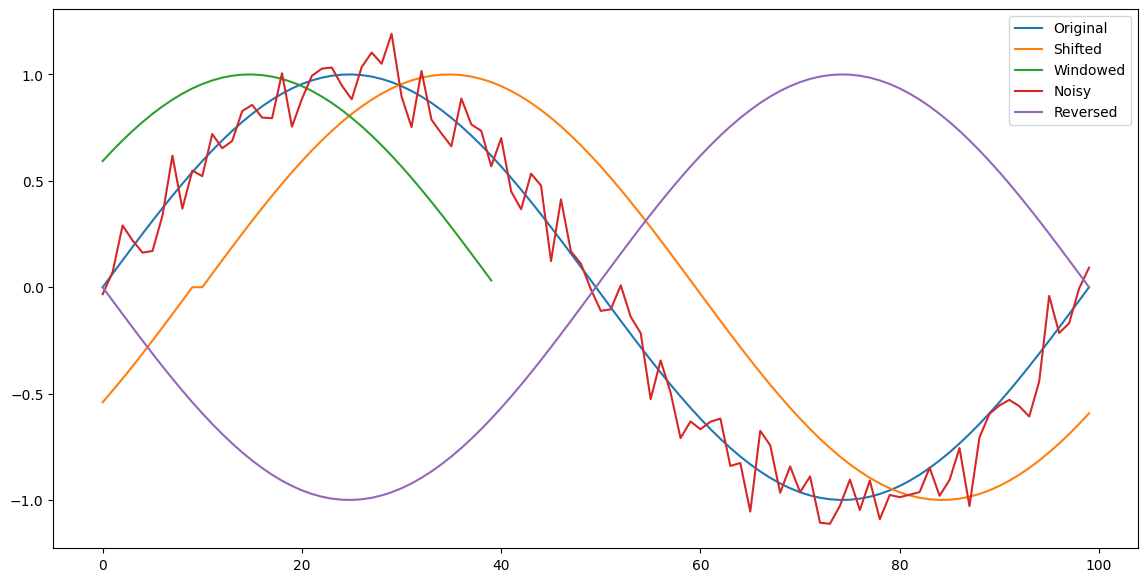

In [32]:
data = np.sin(np.linspace(0, 2 * np.pi, 100))  


def time_shift(data, shift):
    return np.roll(data, shift)


def window_slide(data, start, end):
    return data[start:end]


def add_noise(data, noise_level=0.05):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise


def time_reverse(data):
    return data[::-1]


shifted_data = time_shift(data, 10)
windowed_data = window_slide(data, 10, 50)
noisy_data = add_noise(data, noise_level=0.1)
reversed_data = time_reverse(data)



plt.figure(figsize=(14, 7))
plt.plot(data, label='Original')
plt.plot(shifted_data, label='Shifted')
plt.plot(windowed_data, label='Windowed')
plt.plot(noisy_data, label='Noisy')
plt.plot(reversed_data, label='Reversed')
plt.legend()
plt.show()


In [41]:
def polynomial_features(x, degree=2, include_bias=False):
    """
    Function to generate polynomial features.

    Args:
    - x: input data, shape (m,) or (m, n)
    - degree: the maximum degree of the polynomial
    - include_bias: if True, adds a bias (intercept) feature

    Returns:
    - x_poly: new dataset containing the polynomial features
    """
    # if input is on 1d array, transform it into a 2d array
    if x.ndim == 1:
        x = x[:, np.newaxis]
    
    n_rows, n_cols = x.shape
    x_poly = x

    for d in range(2, degree + 1):
        for feature_index in range(n_cols):
            new_feature = x[:, feature_index] ** d
            new_feature = new_feature.reshape(-1, 1)  # transform the new feature into a column vector
            x_poly = np.hstack((x_poly, new_feature))  # add the new feature 

    if include_bias:
        bias = np.ones((n_rows, 1))  #  one column vector generated
        x_poly = np.hstack((bias, x_poly))  # add the bias column

    return x_poly

x = np.linspace(0, 1, 10)
x_poly = polynomial_features(x, degree=3, include_bias=True)


In [48]:
x = np.linspace(0, 1, 10)[:, np.newaxis]  
y = x**2 + np.random.randn(*x.shape) * 0.1 
x_poly = polynomial_features(x, degree=2, include_bias=True)
x_poly

array([[1.        , 0.        , 0.        ],
       [1.        , 0.11111111, 0.01234568],
       [1.        , 0.22222222, 0.04938272],
       [1.        , 0.33333333, 0.11111111],
       [1.        , 0.44444444, 0.19753086],
       [1.        , 0.55555556, 0.30864198],
       [1.        , 0.66666667, 0.44444444],
       [1.        , 0.77777778, 0.60493827],
       [1.        , 0.88888889, 0.79012346],
       [1.        , 1.        , 1.        ]])

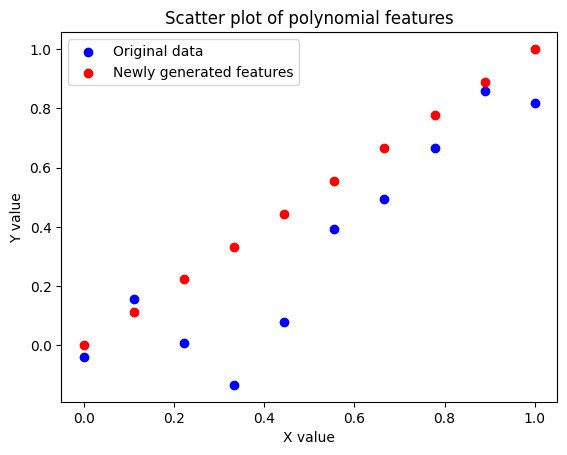

In [49]:
plt.scatter(x, y, color='blue', label='Original data')
plt.scatter(x, x_poly[:, 1], color='red', label='Newly generated features')
plt.xlabel('X value')
plt.ylabel('Y value')
plt.title('Scatter plot of polynomial features')
plt.legend()
plt.show()

In [46]:
def add_fourier_features(x, n_harmonics=5):
    """
    adds Fourier series features to the x data.
    
    Args:
    - x: input data, shape (m, n)
    - n_harmonics: number of harmonics of the Fourier series to add
    
    Returns:
    - x_extended: data with added Fourier features
    """
    n_samples, n_features = x.shape
    x_extended = x.copy()
    
    for feature_index in range(n_features):
        for n in range(1, n_harmonics + 1):
            # add sin and cos features
            sin_feature = np.sin(n * x[:, feature_index])
            cos_feature = np.cos(n * x[:, feature_index])
            x_extended = np.hstack((x_extended, sin_feature[:, np.newaxis], cos_feature[:, np.newaxis]))
    
    return x_extended

x_extended = add_fourier_features(x, n_harmonics=5)

print(x_extended.shape) #(100, 21) - original feature 1 + fourier features 20 (sin 5, cos 5 along x,y axis respectively)


(100, 11)


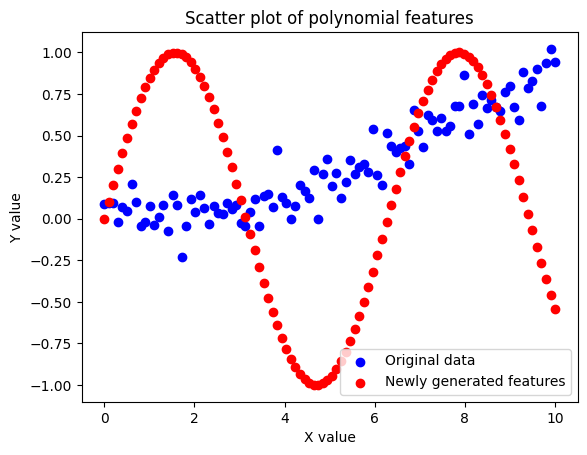

In [47]:
plt.scatter(x, y, color='blue', label='Original data')
plt.scatter(x, x_extended[:, 1], color='red', label='Newly generated features')
plt.xlabel('X value')
plt.ylabel('Y value')
plt.title('Scatter plot of polynomial features')
plt.legend()
plt.show()

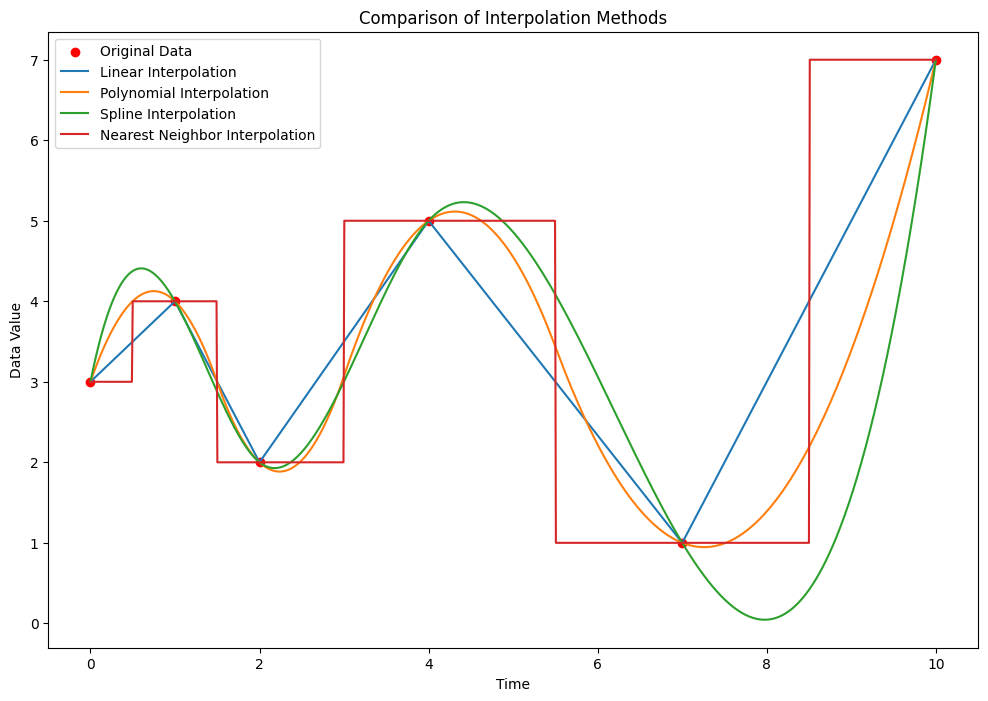

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, splrep, splev

# 예제 시계열 데이터 생성
x = np.array([0, 1, 2, 4, 7, 10])  # 시간
y = np.array([3, 4, 2, 5, 1, 7])   # 데이터 값

# 새로운 데이터 포인트 생성을 위한 범위 설정
x_new = np.linspace(0, 10, 1000)

# 선형 인터폴레이션
linear_interpolate = interp1d(x, y)
y_linear = linear_interpolate(x_new)

# 다항식 인터폴레이션
polynomial_interpolate = interp1d(x, y, kind='quadratic')
y_polynomial = polynomial_interpolate(x_new)

# 스플라인 인터폴레이션
tck = splrep(x, y)
y_spline = splev(x_new, tck)

# 최근접 이웃 인터폴레이션
nearest_interpolate = interp1d(x, y, kind='nearest')
y_nearest = nearest_interpolate(x_new)

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='red', label='Original Data')
plt.plot(x_new, y_linear, label='Linear Interpolation')
plt.plot(x_new, y_polynomial, label='Polynomial Interpolation')
plt.plot(x_new, y_spline, label='Spline Interpolation')
plt.plot(x_new, y_nearest, label='Nearest Neighbor Interpolation')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.title('Comparison of Interpolation Methods')
plt.show()


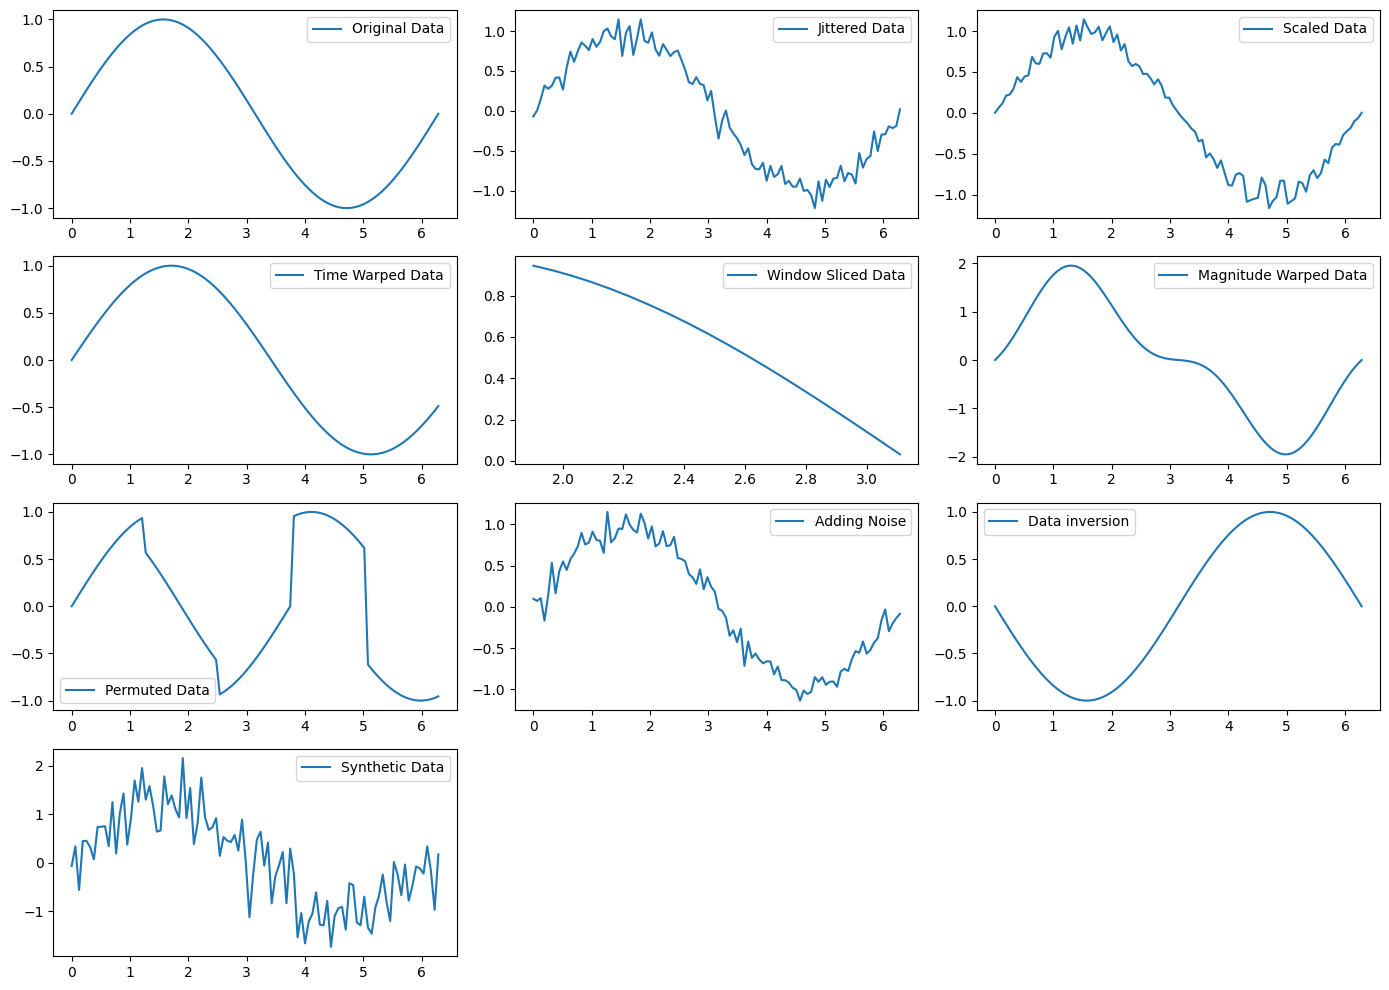

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Original time series data
time = np.linspace(0, 2*np.pi, 100)
original_data = np.sin(time)

# Jittered Data (잡음 추가)
jittered_data = original_data + np.random.normal(0, 0.1, size=original_data.shape)

# Scaled Data (스케일 조정)
scaled_data = original_data * np.random.uniform(0.8, 1.2, size=original_data.shape)

# Time Warped Data (시간 왜곡)
time_warp = np.linspace(0, 2*np.pi, 100) * np.random.uniform(0.8, 1.2)
warped_function = interp1d(time_warp, original_data, fill_value="extrapolate")
time_warped_data = warped_function(time)

# Window Sliced Data (윈도우 슬라이싱)
window_size = 20
start_index = 30
window_sliced_data = original_data[start_index:start_index+window_size]

# Magnitude Warped Data (크기 왜곡)  
magnitude_warped_data = original_data * (np.sin(np.linspace(0, 3*np.pi, original_data.size)) + 1.1)

# Permuted Data (순서 뒤섞기)
segments = 5
chunk_size = len(original_data) // segments
permutation_order = np.random.permutation(segments)
permuted_data = np.concatenate([original_data[i*chunk_size:(i+1)*chunk_size] for i in permutation_order])

# 노이즈 추가 (Adding Noise)
noise_added_data = original_data + np.random.normal(0, 0.1, size=original_data.shape)

# 데이터 반전 (Data inversion)
data_inversion = -original_data

# 합성 데이터 생성 (Synthetic Data Generation)
synthetic_data = original_data + np.random.normal(0, 0.5, size=original_data.shape)


# Plot all types in a single panel
plt.figure(figsize=(14, 10))

# Original Data
plt.subplot(4, 3, 1)
plt.plot(time, original_data, label='Original Data')
plt.legend()

# Jittered Data
plt.subplot(4, 3, 2)
plt.plot(time, jittered_data, label='Jittered Data')
plt.legend()

# Scaled Data
plt.subplot(4, 3, 3)
plt.plot(time, scaled_data, label='Scaled Data')
plt.legend()

# Time Warped Data
plt.subplot(4, 3, 4)
plt.plot(time, time_warped_data, label='Time Warped Data')
plt.legend()

# Window Sliced Data
plt.subplot(4, 3, 5)
time_window = time[start_index:start_index+window_size]
plt.plot(time_window, window_sliced_data, label='Window Sliced Data')
plt.legend()

# Magnitude Warped Data
plt.subplot(4, 3, 6)
plt.plot(time, magnitude_warped_data, label='Magnitude Warped Data')
plt.legend()

# Permuted Data
plt.subplot(4, 3, 7)
plt.plot(time, permuted_data, label='Permuted Data')
plt.legend()

# Adding Noise
plt.subplot(4, 3, 8)
plt.plot(time, noise_added_data, label='Adding Noise')
plt.legend()

# Data inversion
plt.subplot(4, 3, 9)
plt.plot(time, data_inversion, label='Data inversion')
plt.legend()

# Synthetic Data Generation
plt.subplot(4, 3, 10)
plt.plot(time, synthetic_data, label='Synthetic Data')
plt.legend()


plt.tight_layout()
plt.show()


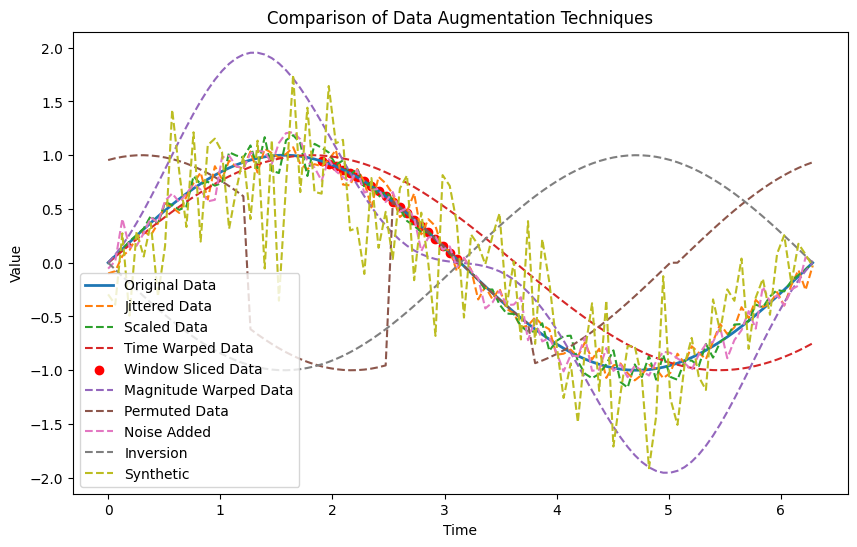

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Set up the original time series data
time = np.linspace(0, 2 * np.pi, 100)
original_data = np.sin(time)

# Create augmented data
jittered_data = original_data + np.random.normal(0, 0.1, size=original_data.shape)
scaled_data = original_data * np.random.uniform(0.8, 1.2, size=original_data.shape)

# Time Warping
time_warp = np.linspace(0, 2 * np.pi, 100) * np.random.uniform(0.8, 1.2)
warped_function = interp1d(time_warp, original_data, fill_value="extrapolate")
time_warped_data = warped_function(time)

# Window Slicing
window_size = 20
start_index = 30
window_sliced_data = np.zeros_like(original_data)
window_sliced_data[start_index:start_index + window_size] = original_data[start_index:start_index + window_size]

# Magnitude Warping
magnitude_warped_data = original_data * (np.sin(np.linspace(0, 3 * np.pi, original_data.size)) + 1.1)

# Permutation
segments = 5
chunk_size = len(original_data) // segments
permutation_order = np.random.permutation(segments)
permuted_data = np.concatenate([original_data[i * chunk_size:(i + 1) * chunk_size] for i in permutation_order])

# 노이즈 추가 (Adding Noise)
noise_added_data = original_data + np.random.normal(0, 0.1, size=original_data.shape)

# 데이터 반전 (Data inversion)
data_inversion = -original_data

# 합성 데이터 생성 (Synthetic Data Generation)
synthetic_data = original_data + np.random.normal(0, 0.5, size=original_data.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time, original_data, label='Original Data', linewidth=2)
plt.plot(time, jittered_data, '--', label='Jittered Data')
plt.plot(time, scaled_data, '--', label='Scaled Data')
plt.plot(time, time_warped_data, '--', label='Time Warped Data')
plt.scatter(time[start_index:start_index + window_size], window_sliced_data[start_index:start_index + window_size], label='Window Sliced Data', color='red')
plt.plot(time, magnitude_warped_data, '--', label='Magnitude Warped Data')
plt.plot(time, permuted_data, '--', label='Permuted Data')
plt.plot(time, noise_added_data, label='Noise Added', linestyle='--')
plt.plot(time, data_inversion, label='Inversion', linestyle='--')
plt.plot(time, synthetic_data, label='Synthetic', linestyle='--')

plt.legend()
plt.title('Comparison of Data Augmentation Techniques')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


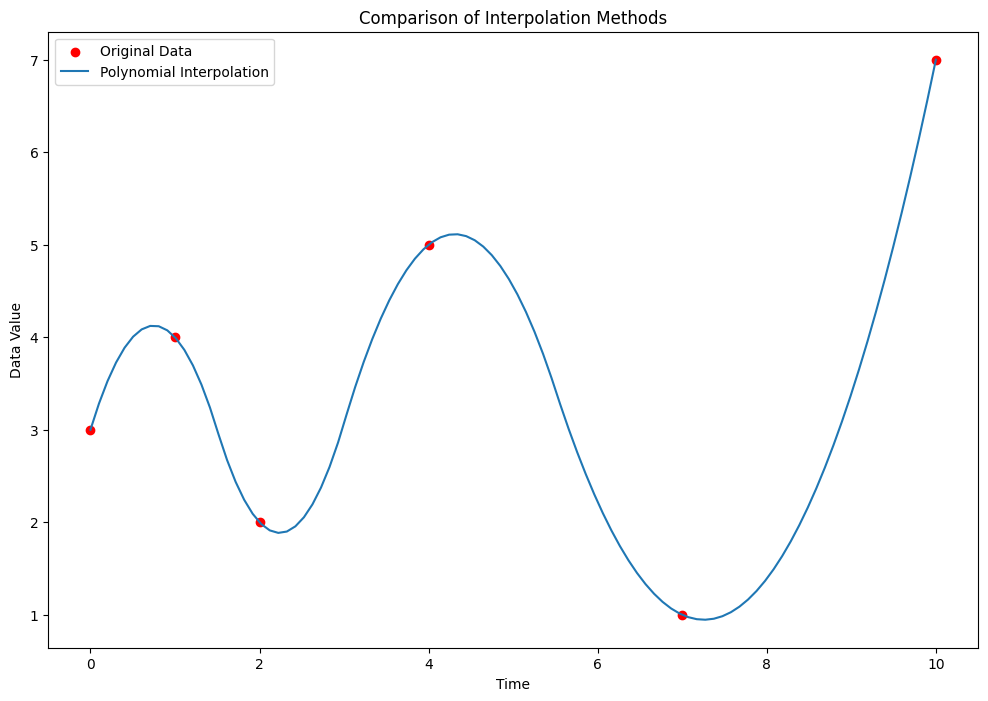

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, splrep, splev

# 예제 시계열 데이터 생성
x = np.array([0, 1, 2, 4, 7, 10])  # 시간
y = np.array([3, 4, 2, 5, 1, 7])   # 데이터 값

# 새로운 데이터 포인트 생성을 위한 범위 설정
x_new = np.linspace(0, 10, 100)

# 다항식 인터폴레이션
polynomial_interpolate = interp1d(x, y, kind='quadratic')
y_polynomial = polynomial_interpolate(x_new)

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='red', label='Original Data')

plt.plot(x_new, y_polynomial, label='Polynomial Interpolation')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.title('Comparison of Interpolation Methods')
plt.show()


In [49]:
# 활성화 함수와 그 미분
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# 입력 데이터와 타겟 데이터
X = x_new  # Interpolated Data
Y = y_new  # Interpolated Data's Target

np.random.seed(42)  # 결과의 일관성을 위해 시드 고정

# 가중치와 바이어스 초기화
input_size = X.shape[1]
hidden_size1 = 15  # 첫 번째 은닉층의 크기
hidden_size2 = 15  # 두 번째 은닉층의 크기
hidden_size3 = 15  # 세 번째 은닉층의 크기
output_size = Y.shape[1]

weights_input_hidden1 = np.random.normal(0, 1, (input_size, hidden_size1))
bias_hidden1 = np.zeros((1, hidden_size1))

weights_hidden1_hidden2 = np.random.normal(0, 1, (hidden_size1, hidden_size2))
bias_hidden2 = np.zeros((1, hidden_size2))

weights_hidden2_hidden3 = np.random.normal(0, 1, (hidden_size2, hidden_size3))
bias_hidden3 = np.zeros((1, hidden_size3))

weights_hidden3_output = np.random.normal(0, 1, (hidden_size3, output_size))
bias_output = np.zeros((1, output_size))

learning_rate = 0.01
epochs = 10000

# 학습 시작
for epoch in range(epochs):
    # 순전파
    hidden1_input = np.dot(X, weights_input_hidden1) + bias_hidden1
    hidden1_output = sigmoid(hidden1_input)
    
    hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + bias_hidden2
    hidden2_output = sigmoid(hidden2_input)
    
    hidden3_input = np.dot(hidden2_output, weights_hidden2_hidden3) + bias_hidden3
    hidden3_output = sigmoid(hidden3_input)
    
    final_output = np.dot(hidden3_output, weights_hidden3_output) + bias_output
    
    # 오차 계산
    error = Y - final_output
    d_error = error * sigmoid_derivative(final_output)
    
    # 역전파 및 가중치 업데이트
    d_hidden3 = d_error.dot(weights_hidden3_output.T) * sigmoid_derivative(hidden3_output)
    weights_hidden3_output += hidden3_output.T.dot(d_error) * learning_rate
    bias_output += np.sum(d_error, axis=0, keepdims=True) * learning_rate
    
    d_hidden2 = d_hidden3.dot(weights_hidden2_hidden3.T) * sigmoid_derivative(hidden2_output)
    weights_hidden2_hidden3 += hidden2_output.T.dot(d_hidden3) * learning_rate
    bias_hidden3 += np.sum(d_hidden3, axis=0, keepdims=True) * learning_rate

    d_hidden1 = d_hidden2.dot(weights_hidden1_hidden2.T) * sigmoid_derivative(hidden1_output)
    weights_hidden1_hidden2 += hidden1_output.T.dot(d_hidden2) * learning_rate
    bias_hidden2 += np.sum(d_hidden2, axis=0, keepdims=True) * learning_rate

    weights_input_hidden1 += X.T.dot(d_hidden1) * learning_rate
    bias_hidden1 += np.sum(d_hidden1, axis=0, keepdims=True) * learning_rate
    
    if epoch % 1000 == 0:
        loss = np.mean(np.square(error))
        print(f"Epoch {epoch}, Loss: {loss}")

# 최종 손실 출력
final_loss = np.mean(np.square(error))
print(f"Final Loss: {final_loss}")


Epoch 0, Loss: 4.1069917629457
Epoch 1000, Loss: 2.0937247788800626
Epoch 2000, Loss: 2.090101164833859
Epoch 3000, Loss: 2.0889567590041804
Epoch 4000, Loss: 2.0932336987213
Epoch 5000, Loss: 2.0979349243571623
Epoch 6000, Loss: 2.0939187226076124
Epoch 7000, Loss: 2.1000633833813995
Epoch 8000, Loss: 2.0926991406596964
Epoch 9000, Loss: 2.082478469566251
Final Loss: 2.0857993240978194


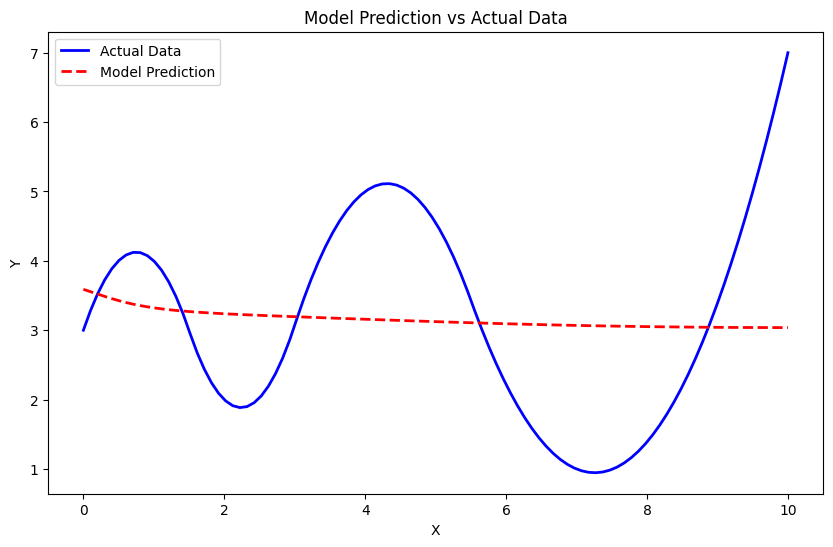

In [50]:
# 모델의 최종 예측 수행
hidden1_input = np.dot(X, weights_input_hidden1) + bias_hidden1
hidden1_output = sigmoid(hidden1_input)

hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + bias_hidden2
hidden2_output = sigmoid(hidden2_input)

hidden3_input = np.dot(hidden2_output, weights_hidden2_hidden3) + bias_hidden3
hidden3_output = sigmoid(hidden3_input)

final_prediction = np.dot(hidden3_output, weights_hidden3_output) + bias_output

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(x_new.flatten(), y_new.flatten(), label='Actual Data', color='blue', linewidth=2)  # 실제 데이터
plt.plot(x_new.flatten(), final_prediction.flatten(), label='Model Prediction', color='red', linestyle='--', linewidth=2)  # 모델 예측
plt.title('Model Prediction vs Actual Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [51]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# 입력 데이터와 타겟 데이터
X = x_new  # Interpolated Data
Y = y_new  # Interpolated Data's Target

np.random.seed(42)  # 결과의 일관성을 위해 시드 고정

# 가중치와 바이어스 초기화
input_size = X.shape[1]
hidden_size1 = 15  # 첫 번째 은닉층의 크기
hidden_size2 = 15  # 두 번째 은닉층의 크기
hidden_size3 = 15  # 세 번째 은닉층의 크기
output_size = Y.shape[1]

weights_input_hidden1 = np.random.normal(0, 1, (input_size, hidden_size1))
bias_hidden1 = np.zeros((1, hidden_size1))

weights_hidden1_hidden2 = np.random.normal(0, 1, (hidden_size1, hidden_size2))
bias_hidden2 = np.zeros((1, hidden_size2))

weights_hidden2_hidden3 = np.random.normal(0, 1, (hidden_size2, hidden_size3))
bias_hidden3 = np.zeros((1, hidden_size3))

weights_hidden3_output = np.random.normal(0, 1, (hidden_size3, output_size))
bias_output = np.zeros((1, output_size))

learning_rate = 0.01
epochs = 10000

# 학습 시작
for epoch in range(epochs):
    # 순전파 (ReLU 활성화 함수 사용)
    hidden1_input = np.dot(X, weights_input_hidden1) + bias_hidden1
    hidden1_output = relu(hidden1_input)
    
    hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + bias_hidden2
    hidden2_output = relu(hidden2_input)
    
    hidden3_input = np.dot(hidden2_output, weights_hidden2_hidden3) + bias_hidden3
    hidden3_output = relu(hidden3_input)
    
    final_output = np.dot(hidden3_output, weights_hidden3_output) + bias_output
    
    # 오차 계산
    error = Y - final_output
    d_error = error * relu_derivative(final_output)
    
    # 역전파 및 가중치 업데이트 (ReLU 미분 적용)
    d_hidden3 = d_error.dot(weights_hidden3_output.T) * relu_derivative(hidden3_output)
    weights_hidden3_output += hidden3_output.T.dot(d_error) * learning_rate
    bias_output += np.sum(d_error, axis=0, keepdims=True) * learning_rate
    
    d_hidden2 = d_hidden3.dot(weights_hidden2_hidden3.T) * relu_derivative(hidden2_output)
    weights_hidden2_hidden3 += hidden2_output.T.dot(d_hidden3) * learning_rate
    bias_hidden3 += np.sum(d_hidden3, axis=0, keepdims=True) * learning_rate

    d_hidden1 = d_hidden2.dot(weights_hidden1_hidden2.T) * relu_derivative(hidden1_output)
    weights_hidden1_hidden2 += hidden1_output.T.dot(d_hidden2) * learning_rate
    bias_hidden2 += np.sum(d_hidden2, axis=0, keepdims=True) * learning_rate

    weights_input_hidden1 += X.T.dot(d_hidden1) * learning_rate
    bias_hidden1 += np.sum(d_hidden1, axis=0, keepdims=True) * learning_rate
    
    if epoch % 1000 == 0:
        loss = np.mean(np.square(error))
        print(f"Epoch {epoch}, Loss: {loss}")

# 최종 손실 출력
final_loss = np.mean(np.square(error))
print(f"Final Loss: {final_loss}")


Epoch 0, Loss: 27303.472194044913
Epoch 1000, Loss: 1.5221788399487063e+31
Epoch 2000, Loss: 1.5221788399487063e+31
Epoch 3000, Loss: 1.5221788399487063e+31
Epoch 4000, Loss: 1.5221788399487063e+31
Epoch 5000, Loss: 1.5221788399487063e+31
Epoch 6000, Loss: 1.5221788399487063e+31
Epoch 7000, Loss: 1.5221788399487063e+31
Epoch 8000, Loss: 1.5221788399487063e+31
Epoch 9000, Loss: 1.5221788399487063e+31
Final Loss: 1.5221788399487063e+31


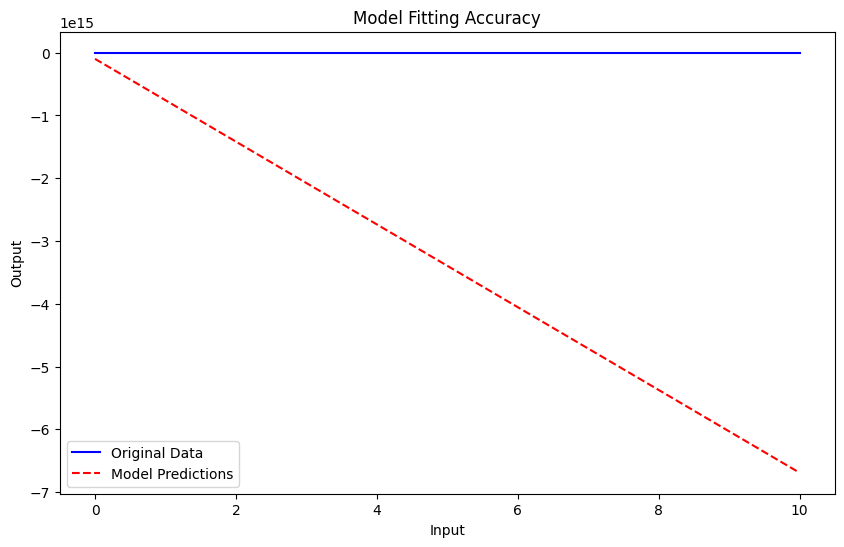

In [55]:
# Generate predictions using the final model
hidden1_input = np.dot(X, weights_input_hidden1) + bias_hidden1
hidden1_output = relu(hidden1_input)

hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + bias_hidden2
hidden2_output = relu(hidden2_input)

hidden3_input = np.dot(hidden2_output, weights_hidden2_hidden3) + bias_hidden3
hidden3_output = relu(hidden3_input)

final_predictions = np.dot(hidden3_output, weights_hidden3_output) + bias_output

# Plot the original data and the model predictions
plt.figure(figsize=(10, 6))
plt.plot(X.flatten(), Y.flatten(), 'b-', label='Original Data')
plt.plot(X.flatten(), final_predictions.flatten(), 'r--', label='Model Predictions')
plt.title('Model Fitting Accuracy')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()


Epoch 0, Loss: 189.72841624508888
Epoch 100, Loss: 179.8325110395589
Epoch 200, Loss: 178.95503318461044
Epoch 300, Loss: 178.18492471340326
Epoch 400, Loss: 177.45446610097935
Epoch 500, Loss: 176.74434860951783
Epoch 600, Loss: 176.04562081605343
Epoch 700, Loss: 175.38520770281147
Epoch 800, Loss: 174.82828966357488
Epoch 900, Loss: 174.3822271063037


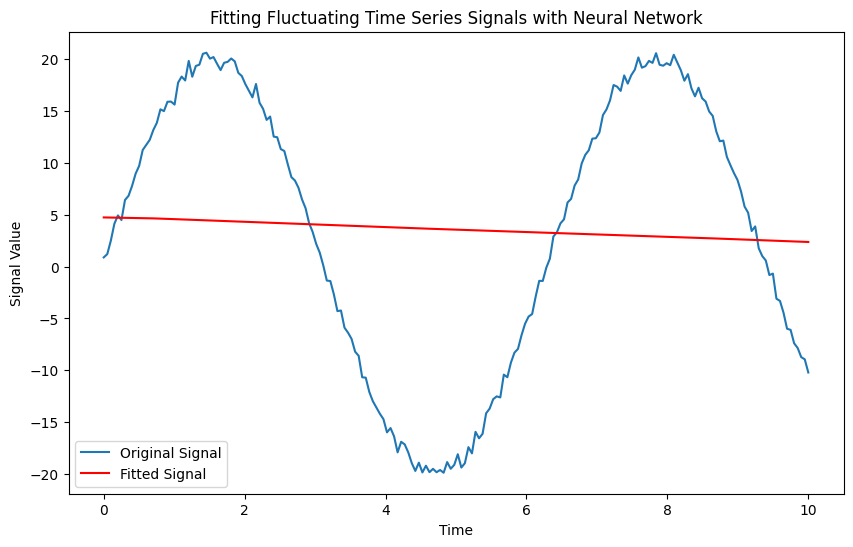

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Generating a synthetic fluctuating time series signal
np.random.seed(0)  # For reproducibility
time = np.linspace(0, 10, 200)  # Time vector
signal = 20*np.sin(time) + np.random.normal(0, 0.5, time.shape)  # Sine wave with noise

# Preparing data for neural network
X = time.reshape(-1, 1)  # Features (reshaping for a single feature)
Y = signal.reshape(-1, 1)  # Target values

# Neural network parameters
input_size = X.shape[1]  # Number of input features
hidden_size1 = 64  # Number of neurons in the first hidden layer
hidden_size2 = 64  # Number of neurons in the second hidden layer
output_size = Y.shape[1]  # Number of output neurons
learning_rate = 0.001  # Learning rate
epochs = 1000  # Number of epochs for training

# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Initialize weights and biases
np.random.seed(42)
weights_input_hidden1 = np.random.randn(input_size, hidden_size1) * 0.1
bias_hidden1 = np.zeros((1, hidden_size1))
weights_hidden1_hidden2 = np.random.randn(hidden_size1, hidden_size2) * 0.1
bias_hidden2 = np.zeros((1, hidden_size2))
weights_hidden2_output = np.random.randn(hidden_size2, output_size) * 0.1
bias_output = np.zeros((1, output_size))

# Training the neural network
for epoch in range(epochs):
    # Forward pass
    hidden1_input = np.dot(X, weights_input_hidden1) + bias_hidden1
    hidden1_output = relu(hidden1_input)
    
    hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + bias_hidden2
    hidden2_output = relu(hidden2_input)
    
    final_output = np.dot(hidden2_output, weights_hidden2_output) + bias_output
    
    # Compute loss (Mean Squared Error)
    loss = np.mean((final_output - Y) ** 2)
    
    # Backpropagation
    d_loss = 2 * (final_output - Y) / Y.shape[0]
    d_weights_hidden2_output = np.dot(hidden2_output.T, d_loss)
    d_bias_output = np.sum(d_loss, axis=0)
    
    d_hidden2 = np.dot(d_loss, weights_hidden2_output.T) * relu_derivative(hidden2_input)
    d_weights_hidden1_hidden2 = np.dot(hidden1_output.T, d_hidden2)
    d_bias_hidden2 = np.sum(d_hidden2, axis=0)
    
    d_hidden1 = np.dot(d_hidden2, weights_hidden1_hidden2.T) * relu_derivative(hidden1_input)
    d_weights_input_hidden1 = np.dot(X.T, d_hidden1)
    d_bias_hidden1 = np.sum(d_hidden1, axis=0)
    
    # Update weights and biases
    weights_hidden2_output -= learning_rate * d_weights_hidden2_output
    bias_output -= learning_rate * d_bias_output
    weights_hidden1_hidden2 -= learning_rate * d_weights_hidden1_hidden2
    bias_hidden2 -= learning_rate * d_bias_hidden2
    weights_input_hidden1 -= learning_rate * d_weights_input_hidden1
    bias_hidden1 -= learning_rate * d_bias_hidden1
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

# Visualization of fitting results
plt.figure(figsize=(10, 6))
plt.plot(time, signal, label='Original Signal')
plt.plot(time, final_output.flatten(), label='Fitted Signal', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.title('Fitting Fluctuating Time Series Signals with Neural Network')
plt.show()


ModuleNotFoundError: No module named 'tensorflow'